# Example of eddy composite with rotation/scaling coordinate transform
## Method:

  1. Select region within $\pm$ N degrees latitude/longitude of eddy centre. This region should be large enough to include the requested locations in the transformed composite coordinates.
  3. Transform from latitude/longitude coordinates to local cartesian coordinates with unit vectors $\mathbf{e}_i$.
  4. Apply a scaling/rotation coordinate transform such that $\mathbf{e'}_1$ is in the direction of large-scale wind and $|\mathbf{e'}_i|=R_{eddy}$.
  5. Resample data in the transformed composite coordinate system.

## Transformation of basis vectors
The basis vectors in the new coordinate system ($\mathbf{e'_i}$) are derived from the original component vectors as follows:

$\mathbf{e}_i = \frac{1}{R_{eddy}}\mathbf{T}\mathbf{e}_i$,

where $R_{eddy}$ is the radius of the specified eddy, $\theta$ is the required anti-clockwise rotation, and $\mathbf{T}$ is a 2D rotation transformation matrix given by

$\mathbf{T} = \begin{pmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta \end{pmatrix}$.


## Transforming vector components in new basis back to the original basis.
The linear transformation of vector components is the inverse of the matrix that transforms the basis vectors. Pure rotational transforms are orthogonal and thus $\mathbf{T^T}\equiv\mathbf{T^{-1}}$. The components of a vector in the original basis ($x_i$) can thus be derived from components in the new basis ($x'_i$) using the the following transformation: 

$\begin{pmatrix} x_1 \\ x_2 \end{pmatrix} = R_{eddy}\mathbf{T^T}\begin{pmatrix} x'_1 \\ x'_2 \end{pmatrix},$

where 

$\mathbf{x} = x_1 \mathbf{e}_1 + x_2 \mathbf{e}_2 = x'_1 \mathbf{e}'_1 + x'_2 \mathbf{e}'_2$.

In [2]:
from pathlib import Path

import intake
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
import numpy as np
import scipy

import xarray as xr
xr.set_options(keep_attrs=True)

import eddytransform
import importlib
importlib.reload(eddytransform)

<module 'eddytransform' from '/etc/ecmwf/nfs/dh2_home_a/neam/code/eddytransform/eddytransform.py'>

## Read data for an example eddy location

In [3]:
# Specify EERIE data
CATALOG = "/home/necr/EERIE/intake_atos/eerie.yaml"
MODEL = "ifs-amip"
DATASET = "2D_24h_0.1deg"
EXP = 'tco1279-eerie_production_202407'
ROOTDIR = "/hpcperm/necr/EERIE/"
DOMAIN_HALF_WIDTH_IN_DEGREES = 10 # Used to select of composite data before resampling to avoid loading global data.
TIME_IDX = 10 # User-specified time index to select data from catalogue (e.g. from tracking algorithm)
EDDY_LON = -71 # User-specified eddy location (e.g. from tracking algorithm)
EDDY_LAT = 39.5

In [4]:
# Read data and select domain centr
catalog = intake.open_catalog(CATALOG)
ds = eddytransform.reshape_latlon_1d_to_latlon_2d(catalog[MODEL][EXP][DATASET].to_dask())

# Select a region surrounding eddy with sufficient buffer for resampling in rotated/scaled coordinates.
ds_region = ds.isel(time=TIME_IDX).sel(
    lon=slice(EDDY_LON-DOMAIN_HALF_WIDTH_IN_DEGREES, EDDY_LON+DOMAIN_HALF_WIDTH_IN_DEGREES),
    lat=slice(EDDY_LAT-DOMAIN_HALF_WIDTH_IN_DEGREES, EDDY_LAT+DOMAIN_HALF_WIDTH_IN_DEGREES),
)

/perm/neam/conda/envs/env_gribscan2360/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


## Transform and resample data

In [5]:
# Parameters coordinate transformation
EDDY_RADIUS = 100 # User-specified eddy radius in km.
AVG_WIND_EDDY_RADIUSES = 2 # Number of eddy radiuses used for calculating direction of large-scale winds. 
RESAMPLE_EDDY_RADIUSES = 3 # Number of eddy radiuses to sample in transformed composite coordinates.
RESAMPLE_DENSITY = 30 # Number of data points per eddy radius in transformed composite coordinates.
UPARAM = "avg_10u"
VPARAM = "avg_10v"
COMPOSITE_PARAM = "avg_sst"

In [5]:
# Create a local cartesian coordinate system with (x,y) specifing distance from eddy in km.
x, y = eddytransform.get_local_cartesian_coords(
    ds_region["lat"].data,
    ds_region["lon"].data,
)

# Create the grid for transformed coordinate system
transformed_x, transformed_y = eddytransform.create_transformed_coordinates(
    RESAMPLE_EDDY_RADIUSES,
    RESAMPLE_DENSITY,
)

# Find direction of large-scale wind (averaged over within specified number of km from eddy centre)
wind_direction_in_radians_from_x = eddytransform.calc_direction_of_average_winds(
    x,
    y,
    ds_region[UPARAM].values,
    ds_region[VPARAM].values,
    distance_from_eddy_threshold=AVG_WIND_EDDY_RADIUSES*EDDY_RADIUS,
    lats = ds_region.lat.values,
)

# Find coordinates of requested locations in local cartesian coordinate system
sample_position_vectors_in_original_coords = eddytransform.create_position_vectors_in_original_coords(
    transformed_x,
    transformed_y,
    wind_direction_in_radians_from_x,
    EDDY_RADIUS,
)

# Resample data into the transformed coordinate system
resampled_data_in_transformed_coords = eddytransform.interpolate_data_to_sample_locations(
    ds_region[COMPOSITE_PARAM].values,
    x,
    y,
    transformed_x,
    transformed_y,
    sample_position_vectors_in_original_coords,
)

## Example plots

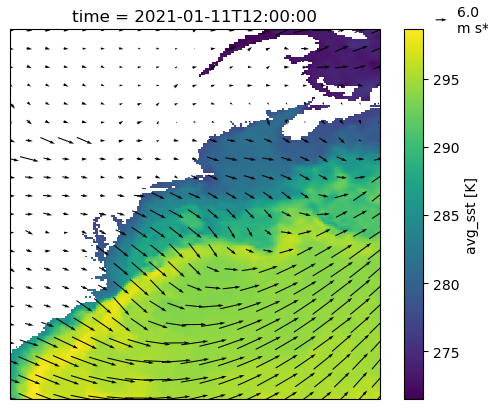

In [6]:
# Plot original data on lat-lon grid
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ds_region[COMPOSITE_PARAM].plot(transform=ccrs.PlateCarree())
ds_region_resampled = ds_region.isel(lon=slice(None,None, 10),lat=slice(None,None, 10))
quiver = ds_region_resampled.plot.quiver(x='lon', y='lat', u='avg_10u', v='avg_10v', scale=200)      

Text(0.5, 1.0, 'avg_sst data on local cartesian x-y grid.')

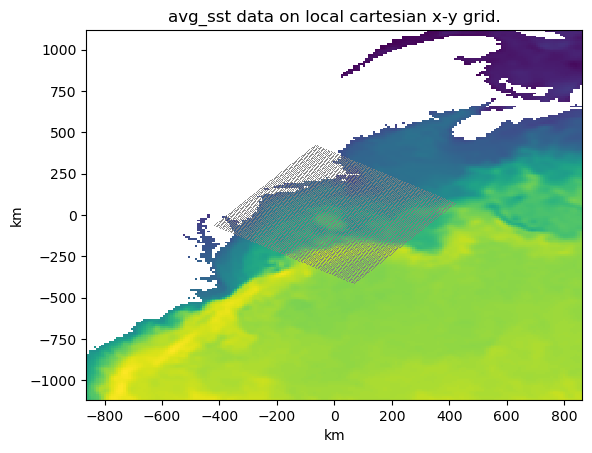

In [7]:
# Plot original data on local cartesian x-y 
plt.pcolormesh(x, y, ds_region[COMPOSITE_PARAM])
plt.xlabel("km")
plt.ylabel("km")

# Add sample locations from rotated/scaled composite grid
plt.plot(
    np.array(sample_position_vectors_in_original_coords[0,:]).squeeze(),
    np.array(sample_position_vectors_in_original_coords[1,:]).squeeze(),
    ",", 
    color="0.5",
    alpha=0.9,
)
plt.title(f"{COMPOSITE_PARAM} data on local cartesian x-y grid.")

Text(0.5, 1.0, 'avg_sst data on rotated/scaled cartesian x-y grid.')

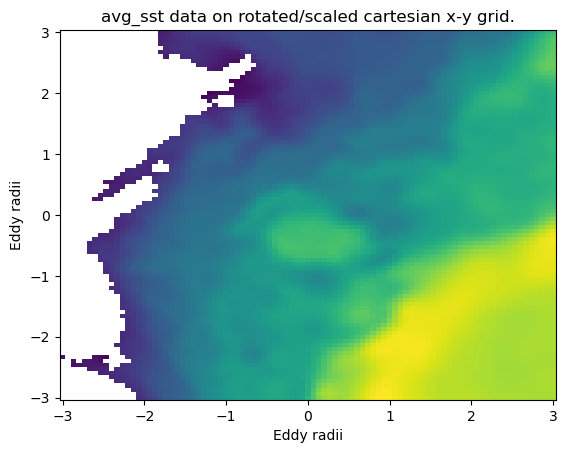

In [8]:
# Plot composte data on rotated/scaled coordinate system 
plt.pcolormesh(transformed_x, transformed_y, resampled_data_in_transformed_coords)
plt.xlabel("Eddy radii")
plt.ylabel("Eddy radii")
plt.title(f"{COMPOSITE_PARAM} data on rotated/scaled cartesian x-y grid.")

# Same with function

In [6]:
importlib.reload(eddytransform)

<module 'eddytransform' from '/etc/ecmwf/nfs/dh2_home_a/neam/code/eddytransform/eddytransform.py'>

In [16]:
transform_settings = dict(
    DOMAIN_HALF_WIDTH_IN_DEGREES = 10, # domain half width
    EDDY_RADIUS = 100, # User-specified eddy radius in km.
    AVG_WIND_EDDY_RADIUSES = 2, # Number of eddy radiuses used for calculating direction of large-scale winds. 
    RESAMPLE_EDDY_RADIUSES = 3, # Number of eddy radiuses to sample in transformed composite coordinates.
    RESAMPLE_DENSITY = 30, # Number of data points per eddy radius in transformed composite coordinates.
    UPARAM = "avg_10u", 
    VPARAM = "avg_10v"
)

In [8]:
transformed_x2, transformed_y2, resampled_data_in_transformed_coords2 = eddytransform.transform_sample_point(
    ds,
    COMPOSITE_PARAM, # = "avg_sst"
    '2021-01-11 12:00', # time-index
    EDDY_LON, # eddy center longitude
    EDDY_LAT, # eddy center latitude
    **transform_settings
    # DOMAIN_HALF_WIDTH_IN_DEGREES, # domain half width
    # EDDY_RADIUS = 100, # User-specified eddy radius in km.
    # AVG_WIND_EDDY_RADIUSES = 2, # Number of eddy radiuses used for calculating direction of large-scale winds. 
    # RESAMPLE_EDDY_RADIUSES = 3, # Number of eddy radiuses to sample in transformed composite coordinates.
    # RESAMPLE_DENSITY = 30, # Number of data points per eddy radius in transformed composite coordinates.
    # UPARAM = "avg_10u", 
    # VPARAM = "avg_10v"
)

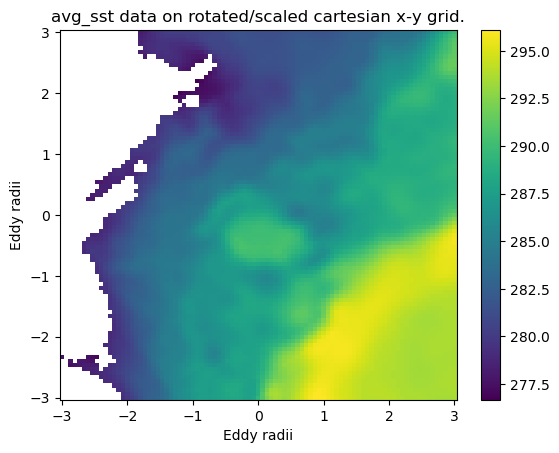

In [9]:
# Plot composte data on rotated/scaled coordinate system 
plt.pcolormesh(transformed_x2, transformed_y2, resampled_data_in_transformed_coords2)
plt.xlabel("Eddy radii")
plt.ylabel("Eddy radii")
plt.title(f"{COMPOSITE_PARAM} data on rotated/scaled cartesian x-y grid.")
plt.colorbar()

In [13]:
transformed_x2.shape

(91,)

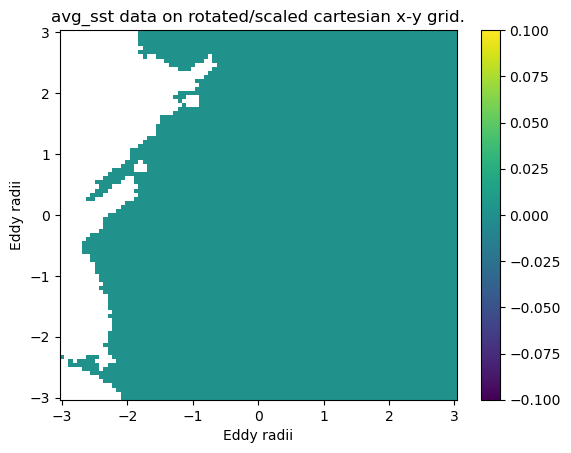

In [27]:
# Plot composte data on rotated/scaled coordinate system 
plt.pcolormesh(transformed_x2, transformed_y2, resampled_data_in_transformed_coords2 - resampled_data_in_transformed_coords)
plt.xlabel("Eddy radii")
plt.ylabel("Eddy radii")
plt.title(f"{COMPOSITE_PARAM} data on rotated/scaled cartesian x-y grid.")
plt.colorbar()

In [59]:
importlib.reload(eddytransform)

<module 'eddytransform' from '/etc/ecmwf/nfs/dh2_home_a/neam/code/eddytransform/eddytransform.py'>

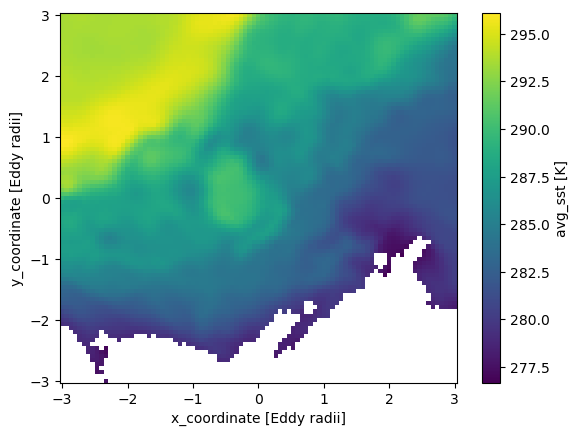

In [63]:
eddy_out['avg_sst'].plot()

In [55]:
# transformed_x2
out = xr.Dataset(coords={'x': transformed_x2, 'y': transformed_y2})
out[COMPOSITE_PARAM] = xr.DataArray(dims=['x','y'],coords={'x':transformed_x2,'y':transformed_y2},data=resampled_data_in_transformed_coords2)

out[COMPOSITE_PARAM].attrs = ds[COMPOSITE_PARAM].attrs

out['x'].attrs['long_name'] = 'x_coordinate'
out['x'].attrs['units'] = 'Eddy radii'
out['y'].attrs['long_name'] = 'y_coordinate'
out['y'].attrs['units'] = 'Eddy radii'

out = out.transpose()

out['time'] = TIME_IDX
out['lon'] = EDDY_LON
out['lat'] = EDDY_LAT

out.attrs['DOMAIN_HALF_WIDTH_IN_DEGREES'] = DOMAIN_HALF_WIDTH_IN_DEGREES
out.attrs['EDDY_RADIUS'] = EDDY_RADIUS
out.attrs['AVG_WIND_EDDY_RADIUSES'] = AVG_WIND_EDDY_RADIUSES
out.attrs['RESAMPLE_EDDY_RADIUSES'] = RESAMPLE_EDDY_RADIUSES
out.attrs['RESAMPLE_DENSITY'] = RESAMPLE_DENSITY
out.attrs['UPARAM'] = UPARAM
out.attrs['VPARAM'] = VPARAM


In [56]:
out

<xarray.Dataset> Size: 68kB
Dimensions:  (x: 91, y: 91)
Coordinates:
  * x        (x) float64 728B -3.0 -2.933 -2.867 -2.8 ... 2.8 2.867 2.933 3.0
  * y        (y) float64 728B -3.0 -2.933 -2.867 -2.8 ... 2.8 2.867 2.933 3.0
Data variables:
    avg_sst  (y, x) float64 66kB nan nan nan nan nan ... 291.0 290.8 290.3 289.8
    time     int64 8B 10
    lon      int64 8B -71
    lat      float64 8B 39.5
Attributes:
    DOMAIN_HALF_WIDTH_IN_DEGREES:  10
    EDDY_RADIUS:                   100
    AVG_WIND_EDDY_RADIUSES:        2
    RESAMPLE_EDDY_RADIUSES:        3
    RESAMPLE_DENSITY:              30
    UPARAM:                        avg_10u
    VPARAM:                        avg_10v

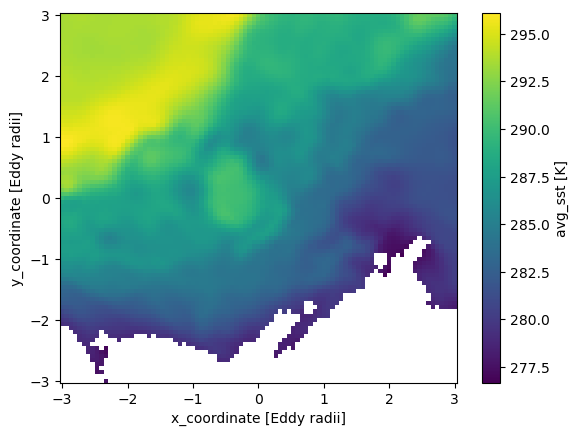

In [49]:
out['avg_sst'].plot()#x='x',y='y')

In [64]:
eddy_out = eddytransform.transform_eddy(
    ds,
    COMPOSITE_PARAM, # = "avg_sst"
    '2021-01-11 12:00', # time-index
    EDDY_LON, # eddy center longitude
    EDDY_LAT, # eddy center latitude
    **transform_settings
    # DOMAIN_HALF_WIDTH_IN_DEGREES, # domain half width
    # EDDY_RADIUS = 100, # User-specified eddy radius in km.
    # AVG_WIND_EDDY_RADIUSES = 2, # Number of eddy radiuses used for calculating direction of large-scale winds. 
    # RESAMPLE_EDDY_RADIUSES = 3, # Number of eddy radiuses to sample in transformed composite coordinates.
    # RESAMPLE_DENSITY = 30, # Number of data points per eddy radius in transformed composite coordinates.
    # UPARAM = "avg_10u", 
    # VPARAM = "avg_10v"
)

In [5]:
importlib.reload(eddytransform)

<module 'eddytransform' from '/etc/ecmwf/nfs/dh2_home_a/neam/code/eddytransform/eddytransform.py'>

In [45]:
tracks0 = eddytransform.load_eddy_tracks('anticyclonic')

In [47]:
tracks2021 = tracks0.sel(obs=tracks0['year'] == 2021)

In [77]:
tracks = tracks0.sel(obs=tracks0['time'] == tracks0['time'][0])

In [12]:
# tracks = tracks0.sel(obs=tracks0['track'] == tracks2021['track'][0])
tracks = tracks2021.sel(obs=tracks2021['track'] == tracks2021['track'][0])

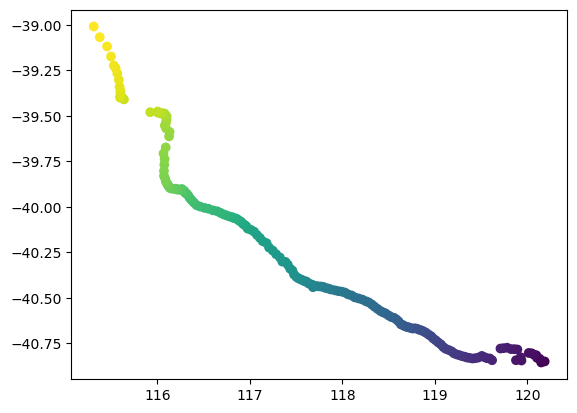

In [99]:
plt.scatter(tracks['longitude'],tracks['latitude'],c=tracks['time'])

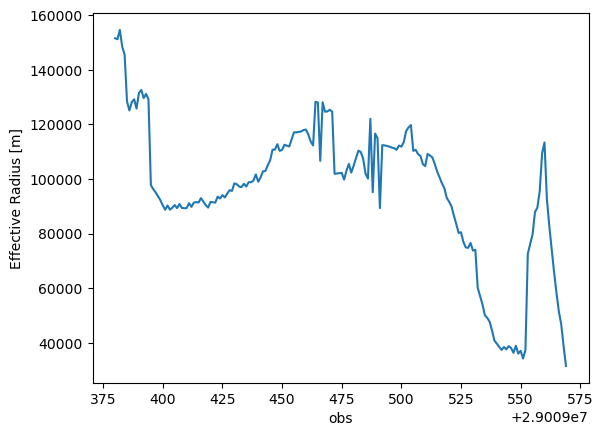

In [102]:
tracks['effective_radius'].plot()

In [103]:
tracki = tracks.isel(obs=0)

In [110]:
tracki['obs']#['effective_radius'].load()

<xarray.DataArray 'obs' ()> Size: 8B
array(29009380)
Coordinates:
    obs      int64 8B 29009380

In [13]:
importlib.reload(eddytransform)

<module 'eddytransform' from '/etc/ecmwf/nfs/dh2_home_a/neam/code/eddytransform/eddytransform.py'>

In [14]:
tracks

<xarray.Dataset> Size: 176kB
Dimensions:                        (obs: 190, NbSample: 20)
Coordinates:
  * obs                            (obs) int64 2kB 29009380 ... 29009569
Dimensions without coordinates: NbSample
Data variables: (12/29)
    amplitude                      (obs) float64 2kB ...
    cost_association               (obs) float32 760B ...
    effective_area                 (obs) float32 760B ...
    effective_contour_height       (obs) float32 760B ...
    effective_contour_latitude     (obs, NbSample) float64 30kB ...
    effective_contour_longitude    (obs, NbSample) float64 30kB ...
    ...                             ...
    speed_contour_shape_error      (obs) float64 2kB ...
    speed_radius                   (obs) float64 2kB ...
    time                           (obs) datetime64[ns] 2kB 2021-01-01T12:00:...
    track                          (obs) uint32 760B ...
    uavg_profile                   (obs, NbSample) float64 30kB ...
    year                           (obs) int64 2kB 2021 2021 2021 ... 2021 2021
Attributes: (12/13)
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    ...                        ...
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [17]:
eddies = eddytransform.loop_over_eddies(
    ds,
    tracks,#.isel(obs=slice(10)),
    ['avg_sst','tprate'],
    **transform_settings
)

Composite parameters:  ['avg_sst', 'tprate']
Loop over 190 eddies
0
['avg_sst', np.datetime64('2021-01-01T12:00:00.000000000'), array(120.18733, dtype=float32), array(-40.848625, dtype=float32), 10, np.float64(152.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['tprate', np.datetime64('2021-01-01T12:00:00.000000000'), array(120.18733, dtype=float32), array(-40.848625, dtype=float32), 10, np.float64(152.0), 2, 3, 30, 'avg_10u', 'avg_10v']
1
['avg_sst', np.datetime64('2021-01-02T12:00:00.000000000'), array(120.14989, dtype=float32), array(-40.854393, dtype=float32), 10, np.float64(151.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['tprate', np.datetime64('2021-01-02T12:00:00.000000000'), array(120.14989, dtype=float32), array(-40.854393, dtype=float32), 10, np.float64(151.0), 2, 3, 30, 'avg_10u', 'avg_10v']
2
['avg_sst', np.datetime64('2021-01-03T12:00:00.000000000'), array(120.144714, dtype=float32), array(-40.841015, dtype=float32), 10, np.float64(155.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['tprate', np.datet

/perm/neam/conda/envs/env_gribscan2360/lib/python3.12/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension obs because variable obs is not a coordinate. To create an index for obs, please first call `.set_coords('obs')` on this object.
  warnings.warn(


In [164]:
(4*60 +53) / 190

1.5421052631578946

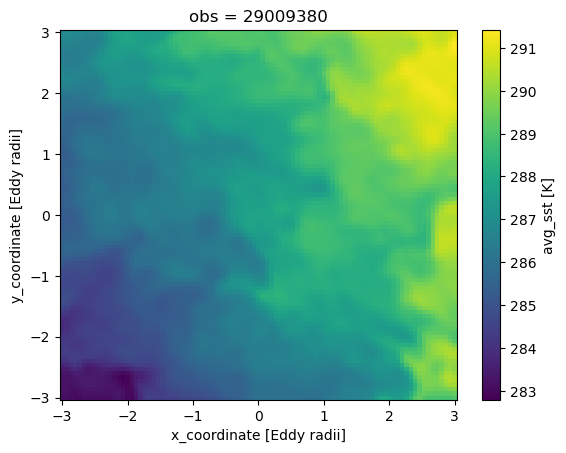

In [140]:
eddytransform.transform_eddy(
    ds,
    'avg_sst',
    tracks.isel(obs=0)['time'],
    tracks.isel(obs=0)['longitude'],
    tracks.isel(obs=0)['latitude'],
    EDDY_RADIUS=int(tracks.isel(obs=0)['effective_radius'] / 1000)
)['avg_sst'].plot()

In [165]:
# eddies['avg_sst'].plot(col='obs',col_wrap=4)
eddies#['avg_sst'].mean('obs').plot()

<xarray.Dataset> Size: 13MB
Dimensions:  (obs: 190, y: 91, x: 91)
Coordinates:
  * obs      (obs) int64 2kB 29009380 29009381 29009382 ... 29009568 29009569
  * x        (x) float64 728B -3.0 -2.933 -2.867 -2.8 ... 2.8 2.867 2.933 3.0
  * y        (y) float64 728B -3.0 -2.933 -2.867 -2.8 ... 2.8 2.867 2.933 3.0
Data variables:
    avg_sst  (obs, y, x) float64 13MB 283.0 283.1 283.1 ... 286.1 286.0 286.0
    time     (obs) datetime64[ns] 2kB 2021-01-01T12:00:00 ... 2021-07-09T12:0...
    lon      (obs) float32 760B 120.2 120.1 120.1 120.1 ... 115.5 115.4 115.3
    lat      (obs) float32 760B -40.85 -40.85 -40.84 ... -39.12 -39.07 -39.01
Attributes:
    DOMAIN_HALF_WIDTH_IN_DEGREES:  10
    EDDY_RADIUS:                   152.0
    AVG_WIND_EDDY_RADIUSES:        2
    RESAMPLE_EDDY_RADIUSES:        3
    RESAMPLE_DENSITY:              30
    UPARAM:                        avg_10u
    VPARAM:                        avg_10v

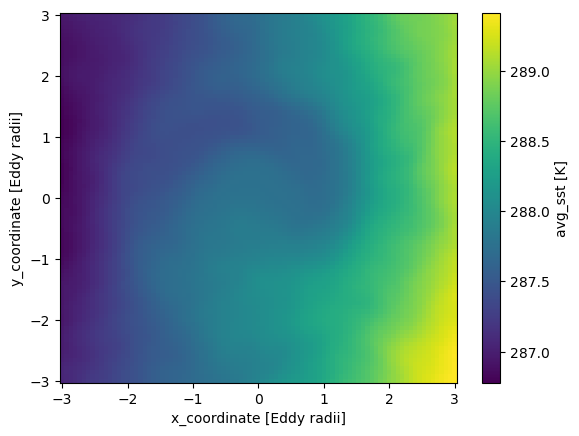

In [18]:
eddies['avg_sst'].mean('obs').plot()

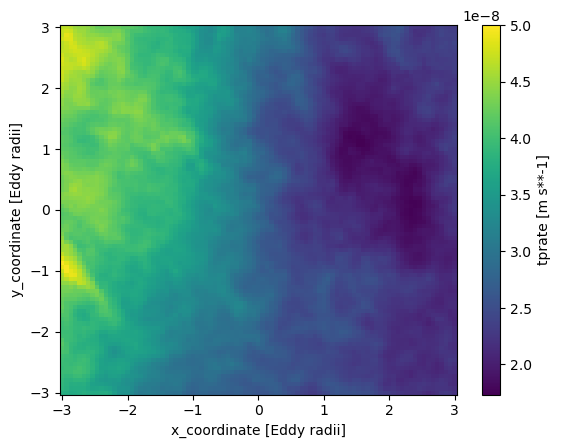

In [20]:
eddies['tprate'].mean('obs').plot()

In [168]:
tracks2021_AG = tracks2021.sel(obs#as (50°S–37°S, 10°E–90°E).

<xarray.Dataset> Size: 1GB
Dimensions:                        (obs: 1204912, NbSample: 20)
Coordinates:
  * obs                            (obs) int64 10MB 29009380 ... 34473578
Dimensions without coordinates: NbSample
Data variables: (12/29)
    amplitude                      (obs) float64 10MB ...
    cost_association               (obs) float32 5MB ...
    effective_area                 (obs) float32 5MB ...
    effective_contour_height       (obs) float32 5MB ...
    effective_contour_latitude     (obs, NbSample) float64 193MB ...
    effective_contour_longitude    (obs, NbSample) float64 193MB ...
    ...                             ...
    speed_contour_shape_error      (obs) float64 10MB ...
    speed_radius                   (obs) float64 10MB ...
    time                           (obs) datetime64[ns] 10MB 2021-01-01T12:00...
    track                          (obs) uint32 5MB ...
    uavg_profile                   (obs, NbSample) float64 193MB ...
    year                           (obs) int64 10MB 2021 2021 2021 ... 2021 2021
Attributes: (12/13)
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    ...                        ...
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [48]:
tracks2021_AG = tracks2021.sel(obs = 
      (tracks2021['longitude'] > 10) 
    & (tracks2021['longitude'] < 90)
    & (tracks2021['latitude'] > -50)
    & (tracks2021['latitude'] < -37)
)
    #as (50°S–37°S, 10°E–90°E).

In [21]:
eddies_AG = eddytransform.loop_over_eddies(
    ds,
    tracks2021_AG.isel(obs=slice(1000)),
    ['avg_sst','tprate','mslhf','msshf','mean10ws'],
    **transform_settings
)

Composite parameters:  ['avg_sst', 'tprate', 'mslhf', 'msshf', 'mean10ws']
Loop over 1000 eddies
0
['avg_sst', np.datetime64('2021-01-01T12:00:00.000000000'), array(16.017029, dtype=float32), array(-49.61904, dtype=float32), 10, np.float64(143.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['tprate', np.datetime64('2021-01-01T12:00:00.000000000'), array(16.017029, dtype=float32), array(-49.61904, dtype=float32), 10, np.float64(143.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['mslhf', np.datetime64('2021-01-01T12:00:00.000000000'), array(16.017029, dtype=float32), array(-49.61904, dtype=float32), 10, np.float64(143.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['msshf', np.datetime64('2021-01-01T12:00:00.000000000'), array(16.017029, dtype=float32), array(-49.61904, dtype=float32), 10, np.float64(143.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['mean10ws', np.datetime64('2021-01-01T12:00:00.000000000'), array(16.017029, dtype=float32), array(-49.61904, dtype=float32), 10, np.float64(143.0), 2, 3, 30, 'avg_10u', 'avg_10v']


/perm/neam/conda/envs/env_gribscan2360/lib/python3.12/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension obs because variable obs is not a coordinate. To create an index for obs, please first call `.set_coords('obs')` on this object.
  warnings.warn(


In [39]:
eddies_AG.to_netcdf('/ec/fws5/lb/project/eerie/testing/eddies_AG.nc')

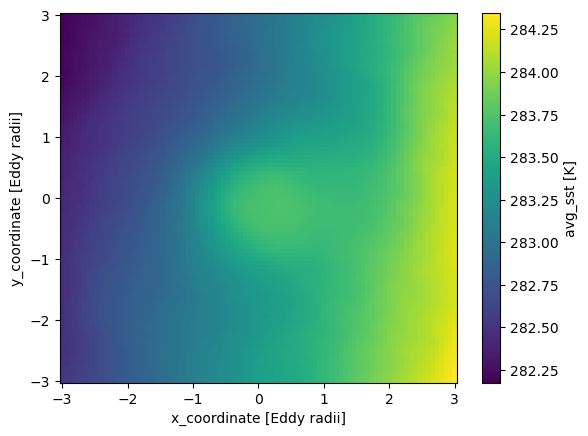

In [35]:
eddies_AG['avg_sst'].mean('obs').plot()#robust=True)

In [36]:
eddies_AG_2t = eddytransform.loop_over_eddies(
    ds,
    tracks2021_AG.isel(obs=slice(1000)),
    ['mean2t'],
    **transform_settings
)

Composite parameters:  ['mean2t']
Loop over 1000 eddies
0
['mean2t', np.datetime64('2021-01-01T12:00:00.000000000'), array(16.017029, dtype=float32), array(-49.61904, dtype=float32), 10, np.float64(143.0), 2, 3, 30, 'avg_10u', 'avg_10v']
1
['mean2t', np.datetime64('2021-01-02T12:00:00.000000000'), array(16.053253, dtype=float32), array(-49.57677, dtype=float32), 10, np.float64(145.0), 2, 3, 30, 'avg_10u', 'avg_10v']
2
['mean2t', np.datetime64('2021-01-03T12:00:00.000000000'), array(16.06868, dtype=float32), array(-49.578224, dtype=float32), 10, np.float64(152.0), 2, 3, 30, 'avg_10u', 'avg_10v']
3
['mean2t', np.datetime64('2021-01-04T12:00:00.000000000'), array(16.087921, dtype=float32), array(-49.574932, dtype=float32), 10, np.float64(155.0), 2, 3, 30, 'avg_10u', 'avg_10v']
4
['mean2t', np.datetime64('2021-01-05T12:00:00.000000000'), array(16.108643, dtype=float32), array(-49.57833, dtype=float32), 10, np.float64(158.0), 2, 3, 30, 'avg_10u', 'avg_10v']
5
['mean2t', np.datetime64('2021-

/perm/neam/conda/envs/env_gribscan2360/lib/python3.12/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension obs because variable obs is not a coordinate. To create an index for obs, please first call `.set_coords('obs')` on this object.
  warnings.warn(


In [38]:
eddies_AG_2t.to_netcdf('/ec/fws5/lb/project/eerie/testing/eddies_AG_2t.nc')

In [59]:
eddies_AG_winds = eddytransform.loop_over_eddies(
    ds,
    tracks2021_AG.isel(obs=slice(10)),
    ['avg_10u','avg_10v'],
    **transform_settings
)

Composite parameters:  ['avg_10u', 'avg_10v']
Loop over 10 eddies
0
['avg_10u', np.datetime64('2021-01-01T12:00:00.000000000'), array(16.017029, dtype=float32), array(-49.61904, dtype=float32), 10, np.float64(143.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['avg_10v', np.datetime64('2021-01-01T12:00:00.000000000'), array(16.017029, dtype=float32), array(-49.61904, dtype=float32), 10, np.float64(143.0), 2, 3, 30, 'avg_10u', 'avg_10v']
1
['avg_10u', np.datetime64('2021-01-02T12:00:00.000000000'), array(16.053253, dtype=float32), array(-49.57677, dtype=float32), 10, np.float64(145.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['avg_10v', np.datetime64('2021-01-02T12:00:00.000000000'), array(16.053253, dtype=float32), array(-49.57677, dtype=float32), 10, np.float64(145.0), 2, 3, 30, 'avg_10u', 'avg_10v']
2
['avg_10u', np.datetime64('2021-01-03T12:00:00.000000000'), array(16.06868, dtype=float32), array(-49.578224, dtype=float32), 10, np.float64(152.0), 2, 3, 30, 'avg_10u', 'avg_10v']
['avg_10v', np.datetime

/perm/neam/conda/envs/env_gribscan2360/lib/python3.12/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension obs because variable obs is not a coordinate. To create an index for obs, please first call `.set_coords('obs')` on this object.
  warnings.warn(


In [ ]:
eddies_AG_winds.to_netcdf('/ec/fws5/lb/project/eerie/testing/eddies_AG_winds.nc')

In [5]:
eddies_AG_winds = xr.open_dataset('/ec/fws5/lb/project/eerie/testing/eddies_AG_winds.nc')

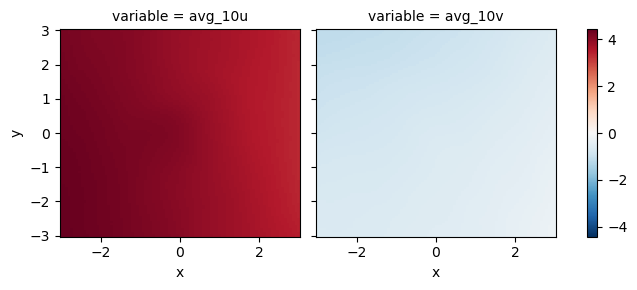

In [7]:
eddies_AG_winds[['avg_10u','avg_10v']].mean('obs').to_array().plot(col='variable')

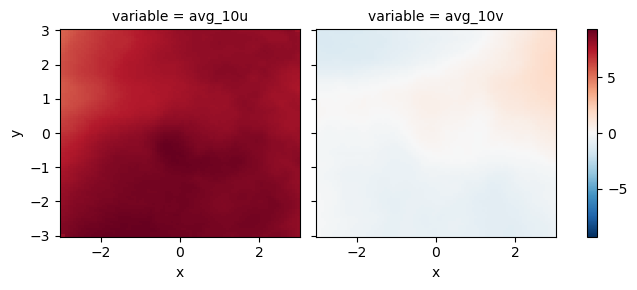

In [61]:
eddies_AG_winds[['avg_10u','avg_10v']].mean('obs').to_array().plot(col='variable')

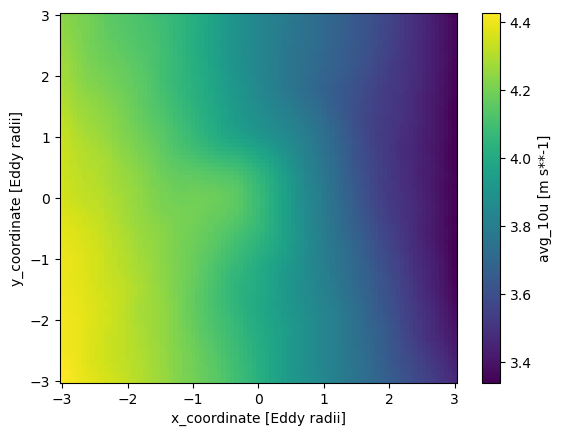

In [10]:
eddies_AG_winds['avg_10u'].mean('obs').plot()

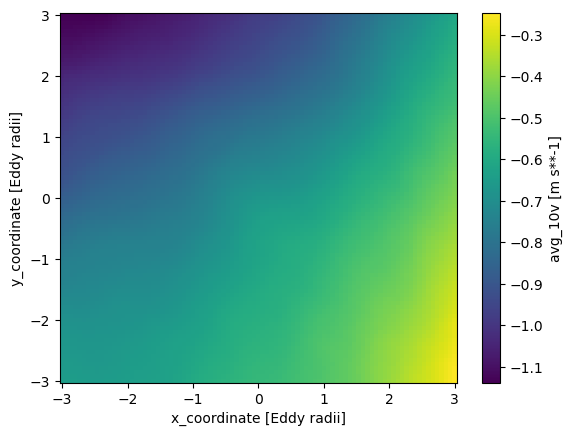

In [11]:
eddies_AG_winds['avg_10v'].mean('obs').plot()

In [40]:
eddies_AG_all = xr.merge([eddies_AG,eddies_AG_2t])

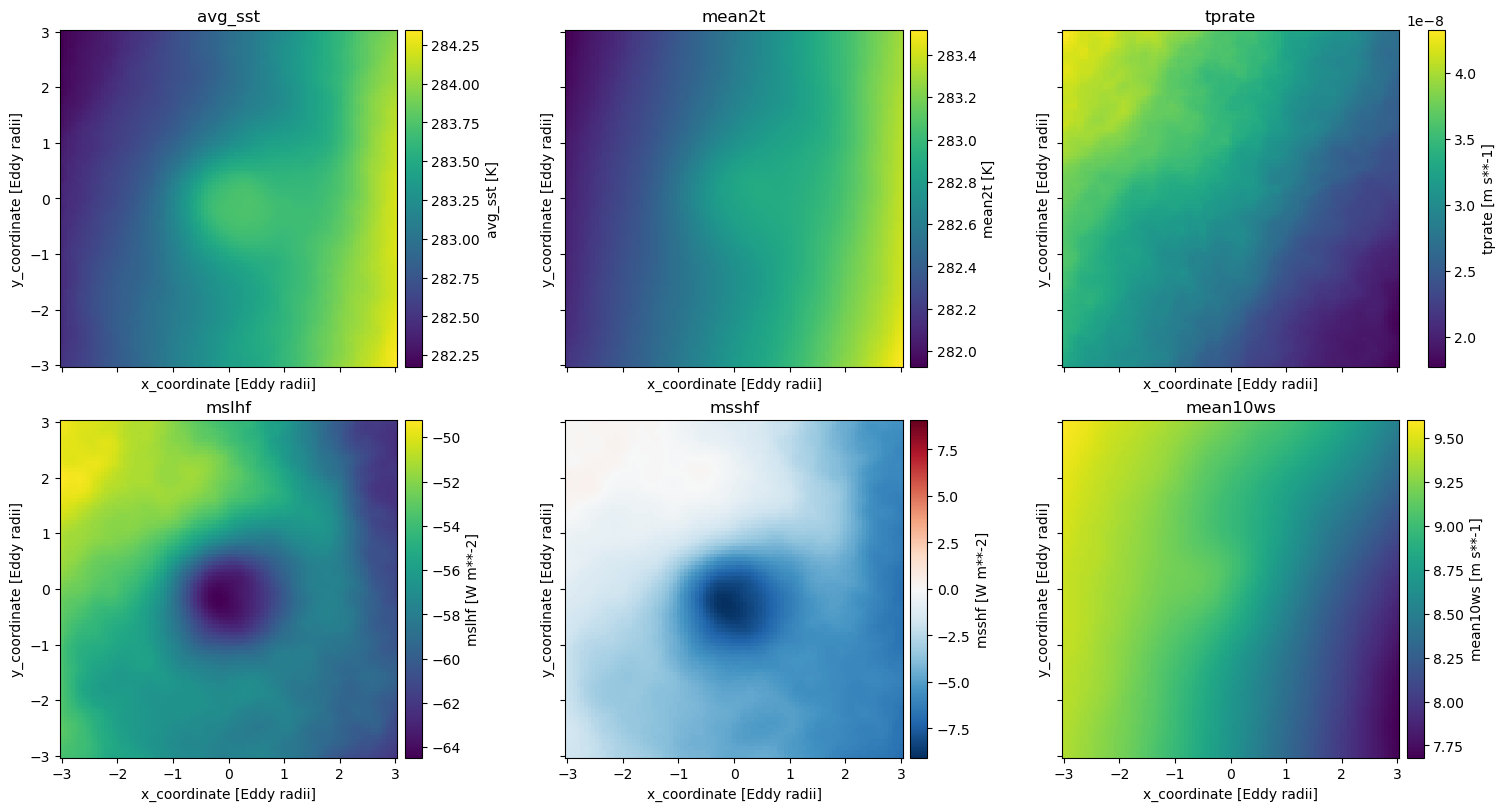

In [50]:
fig, axs = plt.subplots(2,3,sharex=True,sharey=True,constrained_layout=True,figsize=(15,8))
ax = axs.flatten()

i = 0
for param in ['avg_sst','mean2t','tprate','mslhf','msshf','mean10ws']:
    eddies_AG_all[param].mean('obs').plot(ax=ax[i],cbar_kwargs=dict(pad=0.0125))
    ax[i].set_title(param)
    ax[i].set_aspect('equal')
    i += 1

Text(0.5, 1.0, 'first 1000 2021 tracks in AG region')

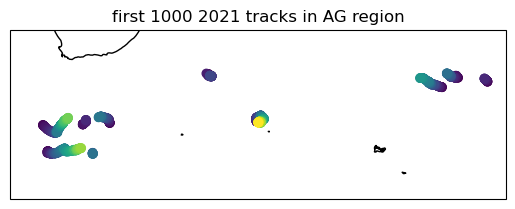

In [17]:
plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.scatter(tracks2021_AG.isel(obs=slice(1000))['longitude'],tracks2021_AG.isel(obs=slice(1000))['latitude'],c=tracks2021_AG.isel(obs=slice(1000))['time'])

plt.gca().coastlines()

# plt.gca().set_extent([10,90,-50,-37])
plt.gca().set_extent([10,90,-50,-30])

plt.title('first 1000 2021 tracks in AG region')

Text(0.5, 1.0, 'all 37518 2021 tracks in AG region')

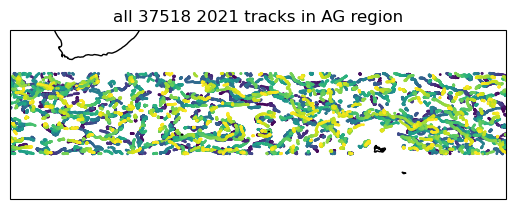

In [22]:
plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.scatter(tracks2021_AG['longitude'],tracks2021_AG['latitude'],c=tracks2021_AG['time'],s=1)

plt.gca().coastlines()

# plt.gca().set_extent([10,90,-50,-37])
plt.gca().set_extent([10,90,-50,-30])

plt.title('all %i 2021 tracks in AG region' % tracks2021_AG['obs'].size)

Text(0.5, 1.0, 'all 3808 2021 tracks in AG region, only sampling every 10th day')

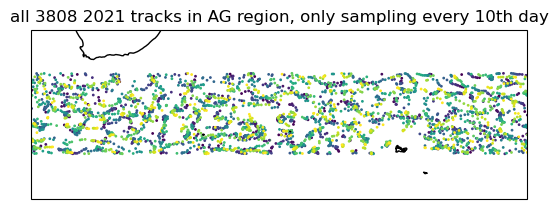

In [67]:
plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.scatter(tracks2021_AG_10days['longitude'],tracks2021_AG_10days['latitude'],c=tracks2021_AG_10days['time'],s=1)

plt.gca().coastlines()

# plt.gca().set_extent([10,90,-50,-37])
plt.gca().set_extent([10,90,-50,-30])

plt.title('all %i 2021 tracks in AG region, only sampling every 10th day' % tracks2021_AG_10days['obs'].size)

In [25]:
import pandas as pd
import cartopy.crs as ccrs

In [54]:
dates = pd.date_range('2021-01-01 12:00','2021-12-31',freq='10D')

In [59]:
dates

DatetimeIndex(['2021-01-01 12:00:00', '2021-01-11 12:00:00',
               '2021-01-21 12:00:00', '2021-01-31 12:00:00',
               '2021-02-10 12:00:00', '2021-02-20 12:00:00',
               '2021-03-02 12:00:00', '2021-03-12 12:00:00',
               '2021-03-22 12:00:00', '2021-04-01 12:00:00',
               '2021-04-11 12:00:00', '2021-04-21 12:00:00',
               '2021-05-01 12:00:00', '2021-05-11 12:00:00',
               '2021-05-21 12:00:00', '2021-05-31 12:00:00',
               '2021-06-10 12:00:00', '2021-06-20 12:00:00',
               '2021-06-30 12:00:00', '2021-07-10 12:00:00',
               '2021-07-20 12:00:00', '2021-07-30 12:00:00',
               '2021-08-09 12:00:00', '2021-08-19 12:00:00',
               '2021-08-29 12:00:00', '2021-09-08 12:00:00',
               '2021-09-18 12:00:00', '2021-09-28 12:00:00',
               '2021-10-08 12:00:00', '2021-10-18 12:00:00',
               '2021-10-28 12:00:00', '2021-11-07 12:00:00',
               '2021-11-

In [62]:
tracks2021_AG_10days = tracks2021_AG.sel(obs=[t in dates for t in tracks2021_AG['time'].values])

In [65]:
tracks2021_AG_10days

<xarray.Dataset> Size: 4MB
Dimensions:                        (obs: 3808, NbSample: 20)
Coordinates:
  * obs                            (obs) int64 30kB 32411083 ... 34465247
Dimensions without coordinates: NbSample
Data variables: (12/29)
    amplitude                      (obs) float64 30kB ...
    cost_association               (obs) float32 15kB ...
    effective_area                 (obs) float32 15kB ...
    effective_contour_height       (obs) float32 15kB ...
    effective_contour_latitude     (obs, NbSample) float64 609kB ...
    effective_contour_longitude    (obs, NbSample) float64 609kB ...
    ...                             ...
    speed_contour_shape_error      (obs) float64 30kB ...
    speed_radius                   (obs) float64 30kB ...
    time                           (obs) datetime64[ns] 30kB 2021-01-01T12:00...
    track                          (obs) uint32 15kB ...
    uavg_profile                   (obs, NbSample) float64 609kB ...
    year                           (obs) int64 30kB 2021 2021 2021 ... 2021 2021
Attributes: (12/13)
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    ...                        ...
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

In [51]:
dates[0]

Timestamp('2021-01-01 00:00:00')

In [42]:
tracks2021_AG['time'][0]

<xarray.DataArray 'time' ()> Size: 8B
array('2021-01-01T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    obs      int64 8B 32411083
Attributes:
    axis:           T
    comment:        Date of this observation
    long_name:      Time
    standard_name:  time
    min:            15706.0
    max:            26337.0

In [31]:
tracks2021_SO = tracks2021.sel(obs = 
      (tracks2021['latitude'] > -60)
    & (tracks2021['latitude'] < -25)
    & (tracks2021['longitude'] > 0)
)


In [71]:
tracks2021_SO_10days = tracks2021_SO.sel(obs=[t in dates for t in tracks2021_SO['time'].values])

In [72]:
tracks2021_SO_10days

<xarray.Dataset> Size: 46MB
Dimensions:                        (obs: 49637, NbSample: 20)
Coordinates:
  * obs                            (obs) int64 397kB 29009380 ... 34465639
Dimensions without coordinates: NbSample
Data variables: (12/29)
    amplitude                      (obs) float64 397kB ...
    cost_association               (obs) float32 199kB ...
    effective_area                 (obs) float32 199kB ...
    effective_contour_height       (obs) float32 199kB ...
    effective_contour_latitude     (obs, NbSample) float64 8MB ...
    effective_contour_longitude    (obs, NbSample) float64 8MB ...
    ...                             ...
    speed_contour_shape_error      (obs) float64 397kB ...
    speed_radius                   (obs) float64 397kB ...
    time                           (obs) datetime64[ns] 397kB 2021-01-01T12:0...
    track                          (obs) uint32 199kB ...
    uavg_profile                   (obs, NbSample) float64 8MB ...
    year                           (obs) int64 397kB 2021 2021 ... 2021 2021
Attributes: (12/13)
    track_extra_variables:     lat_max,lon_max
    track_array_variables:     20
    array_variables:           contour_lat_e,contour_lon_e,contour_lat_s,cont...
    title:                     Anticyclonic
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    ...                        ...
    framework_version:         v3.6.0
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    date_created:              2022-09-21T20:56:43Z
    time_coverage_duration:    P10632D
    time_coverage_start:       1993-01-01T00:00:00Z
    time_coverage_end:         2022-02-09T00:00:00Z

Text(0.5, 1.0, 'all 489662 2021 tracks in SO region')

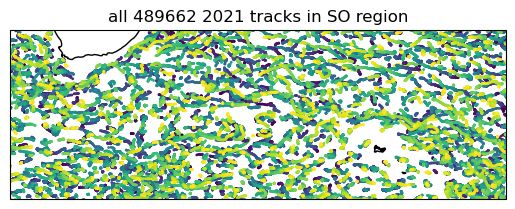

In [80]:
plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.scatter(tracks2021_SO['longitude'],tracks2021_SO['latitude'],c=tracks2021_SO['time'],s=1)

plt.gca().coastlines()

# plt.gca().set_extent([10,90,-50,-37])
plt.gca().set_extent([10,90,-50,-30])

plt.title('all %i 2021 tracks in SO region' % tracks2021_SO['obs'].size)

Text(0.5, 1.0, 'all 49637 2021 tracks in SO region, only sampling every 10th day')

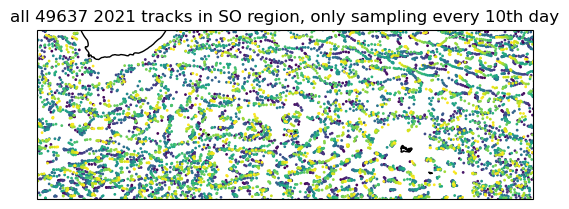

In [75]:
plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.scatter(tracks2021_SO_10days['longitude'],tracks2021_SO_10days['latitude'],c=tracks2021_SO_10days['time'],s=1)

plt.gca().coastlines()

# plt.gca().set_extent([10,90,-50,-37])
plt.gca().set_extent([10,90,-50,-30])

plt.title('all %i 2021 tracks in SO region, only sampling every 10th day' % tracks2021_SO_10days['obs'].size)

Text(0.5, 1.0, 'all 4964 2021 tracks in SO region, only sampling every 10th day, then 10th obs')

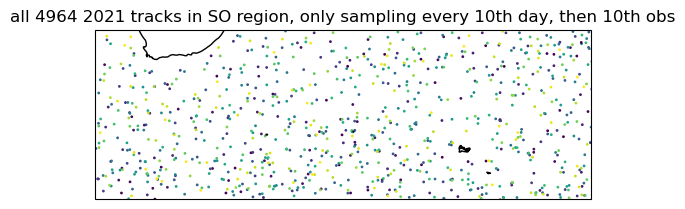

In [78]:
plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
plt.scatter(tracks2021_SO_10days.isel(obs=slice(0,None,10))['longitude'],tracks2021_SO_10days.isel(obs=slice(0,None,10))['latitude'],c=tracks2021_SO_10days.isel(obs=slice(0,None,10))['time'],s=1)

plt.gca().coastlines()

# plt.gca().set_extent([10,90,-50,-37])
plt.gca().set_extent([10,90,-50,-30])

plt.title('all %i 2021 tracks in SO region, only sampling every 10th day, then 10th obs' % tracks2021_SO_10days.isel(obs=slice(0,None,10))['obs'].size)